<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import cv2
from pathlib import Path
import PIL
from PIL import Image

import torchvision
from torchvision import transforms

from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 2070 SUPER, 470.86, 7959 MiB


In [5]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/MFTI/GAN/faces_dataset_small.zip' >'/dev/null'

In [ ]:
# !mkdir saved_examples
# !rm -rf faces_dataset_small/04000/ && mkdir ./faces_dataset_small/faceless
# !mv -v ./faces_dataset_small/* ./faces_dataset_small/faceless/ > /dev/null

In [28]:
data_dir = '/home/paul/Jypyter_Notebooks/MFTI/GAN/PICS'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32 # 16
NUM_EPOCHS = 20
LR = 1e-5 #-5
LR_GEN = 1e-5

CHANNELS_IMG = 3
#Latent space dim
Z_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 10 #5
LAMBDA_GP = 10


RESNET_MEAN = 0.5
RESNET_STD = 0.5
IMAGE_SIZE = 128

WORKERS = 12

SAVE_MODEL = True
LOAD_MODEL = True
CHECKPOINT_GEN = "generator_wgan_70k.pth"
CHECKPOINT_CRITIC = "critic_wgan_70k.pth"

In [29]:
train_files = sorted(list(Path(data_dir).rglob('*png')))
print(f'Number of pictures in dir: {len(train_files)} pcs')

Number of pictures in dir: 66859 pcs


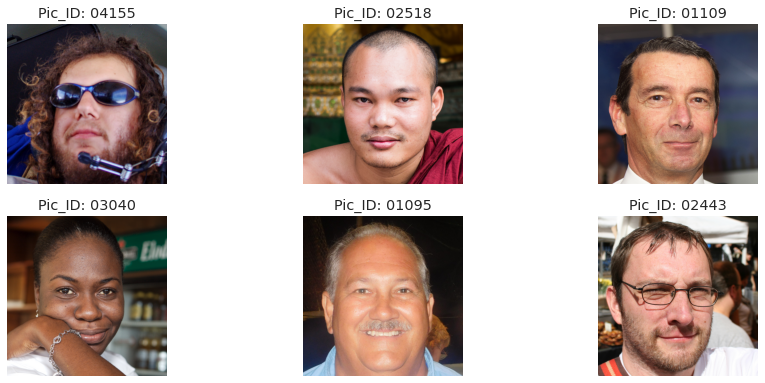

In [30]:
# Load pics
plt.figure(figsize = (15,10))
for i in range(6):
    rand_idx = int(np.random.uniform(0,5000))
    im = PIL.Image.open(train_files[rand_idx])
    plt.subplot(3, 3, i + 1)
    plt.imshow(im)
    label = (train_files[rand_idx]).stem
    plt.title('Pic_ID: ' + str(label))
    plt.axis('off')
plt.show()

In [31]:
class FaceDataSet(Dataset):
    def __init__(self, files,use_cache=False):   
        self.files = files
        self.len_ = len(self.files)
        self.cached_data = []
        self.use_cache = use_cache
        self.transform =transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                            transforms.CenterCrop(IMAGE_SIZE),
                                            transforms.ToTensor(),
                                            transforms.Normalize(
                                                [RESNET_MEAN for _ in range(CHANNELS_IMG)],
                                                [RESNET_STD for _ in range(CHANNELS_IMG)]),
                                            ])
           
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        img_id = file.stem
        return image, img_id
    
    def __getitem__(self,index):
        if not self.use_cache:
            img,img_id = self.load_sample(self.files[index]) 
            img = self.transform(img) 
            self.cached_data.append(img)
        else:
            img = self.cached_data[index]             
        return img
    
    def set_use_cache(self, use_cache):
        if use_cache:
            x_img = tuple(self.cached_data)
            self.cached_data = torch.stack(x_img)
        else:
            self.cached_data = []
        self.use_cache = use_cache
    
    def __len__(self):
        return self.len_

In [32]:
dataset = FaceDataSet(train_files,use_cache=False)

In [33]:
loader = DataLoader(dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    pin_memory=True,
                    num_workers=WORKERS,)

In [34]:
images = next(iter(loader))
assert images.shape == (BATCH_SIZE,CHANNELS_IMG,IMAGE_SIZE,IMAGE_SIZE ), "DSET FAILED"
print(f"image shape: {images.shape}")

image shape: torch.Size([32, 3, 128, 128])


## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [35]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 128 x 128
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=4, padding=1
            ), # out_width = (128 - 3 + 2 ) / 4  = 32   [(W−K+2P)/S]+1.
            nn.LeakyReLU(0.2,inplace=True),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1), #16x16
            self._block(features_d * 2, features_d * 4, 4, 2, 1), # 8X8
            self._block(features_d * 4, features_d * 8, 4, 2, 1), #4X4
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            #nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
             #Layer_norm <-->Instance Norm
            nn.InstanceNorm2d(out_channels,affine=True),
            nn.LeakyReLU(0.2,inplace=True),
        )

    def forward(self, x):
        return self.disc(x)

In [36]:
class Generator(nn.Module):
    def __init__(self, latent_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1  [(W−1)*S - 2*p + (K-1)     +2P)/S]+1.
            self._block(latent_noise, features_g * 16, 4, 1, 0),  # img: 4x4 or *16
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2 , 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g *2, channels_img, kernel_size=4, stride=4, padding=0   # pad=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.net(x)

# UTILS

In [37]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [38]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [39]:
# def initialize_weights(model):
#     classname = model.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(model.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(model.weight.data, 1.0, 0.02)
#         nn.init.constant_(model.bias.data, 0)

In [40]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [41]:
def test():
    N, in_channels, H, W = 8, 3, 128, 128
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Critic(in_channels, 8)
    print(disc(x).shape)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, noise_dim, 1, 1))
    print(gen(z).shape)
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print(gen(z).shape)

In [42]:
test()

torch.Size([8, 1, 1, 1])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])


# TRAIN

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [43]:
# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)
    writer.add_scalar("Loss Gen", loss_gen, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)

In [44]:
def gradient_penalty(critic, real, fake, device="cuda"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(inputs=interpolated_images,
                                 outputs=mixed_scores,
                                 grad_outputs=torch.ones_like(mixed_scores),
                                 create_graph=True,retain_graph=True,
                                 )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [45]:
def generate_examples(gen, n=50, device = device):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1,Z_DIM, 1, 1).to(device)
            img = gen(noise)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

In [46]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Critic(CHANNELS_IMG, FEATURES_DISC).to(device)

gen.apply(initialize_weights)
critic.apply(initialize_weights)

Critic(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel_size=(

In [47]:
opt_gen = torch.optim.Adam(gen.parameters(), lr=LR_GEN, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), lr=LR, betas=(0.0, 0.9))

In [48]:
if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LR,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC, critic, opt_critic,LR,
        )

=> Loading checkpoint
=> Loading checkpoint


In [49]:
fixed_noise = torch.randn(64,Z_DIM, 1, 1).to(device)
writer = SummaryWriter(f"logs_wgan/WGAN")
tensorboard_step = 0

In [50]:
gen.train()
critic.train()
losses_gen = []
losses_critic = []

In [51]:
for epoch in range(NUM_EPOCHS):
    loss_crit_per_epoch = []
    loss_gen_per_epoch = []
    # Target labels not needed! <3 unsupervised
    for batch_idx, real in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)
            opt_critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
            loss_crit_per_epoch.append(loss_critic.item())

        # Train GEN: min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        loss_gen_per_epoch.append(loss_gen.item())

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fixed_fakes = gen(fixed_noise)
            plot_to_tensorboard(writer,
                                loss_critic.item(),
                                loss_gen.item(), 
                                real.detach(),
                                fixed_fakes.detach(),
                                tensorboard_step
                               )
            tensorboard_step += 1

    losses_critic.append(np.mean(loss_crit_per_epoch))
    losses_gen.append(np.mean(loss_gen_per_epoch))
    generate_examples(gen)
    if SAVE_MODEL:
                save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
                save_checkpoint(critic, opt_critic, filename=CHECKPOINT_CRITIC)

Epoch [0/20] Batch 0/2090                   Loss D: 5.5960, loss G: 153.4232
Epoch [0/20] Batch 100/2090                   Loss D: -3.2497, loss G: 125.3733
Epoch [0/20] Batch 200/2090                   Loss D: -9.9211, loss G: 91.1762
Epoch [0/20] Batch 300/2090                   Loss D: -6.2309, loss G: 105.2092
Epoch [0/20] Batch 400/2090                   Loss D: -4.3959, loss G: 96.8884
Epoch [0/20] Batch 500/2090                   Loss D: -1.8748, loss G: 118.6906
Epoch [0/20] Batch 600/2090                   Loss D: -9.3633, loss G: 120.9824
Epoch [0/20] Batch 700/2090                   Loss D: -5.9762, loss G: 131.8757
Epoch [0/20] Batch 800/2090                   Loss D: -7.1526, loss G: 116.2003
Epoch [0/20] Batch 900/2090                   Loss D: -7.8177, loss G: 103.3575
Epoch [0/20] Batch 1000/2090                   Loss D: -9.9788, loss G: 116.4033
Epoch [0/20] Batch 1100/2090                   Loss D: -7.9258, loss G: 162.7529
Epoch [0/20] Batch 1200/2090               

KeyboardInterrupt: 

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
%tensorboard --logdir logs_wgan/WGAN

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [30]:
generated_img_path = './saved_examples'

In [ ]:
# generate_examples(gen)

In [31]:
generated_img = sorted(list(Path(generated_img_path).rglob('*png')))
print(f'Number of pictures in dir: {len(generated_img)} pcs')

Number of pictures in dir: 50 pcs


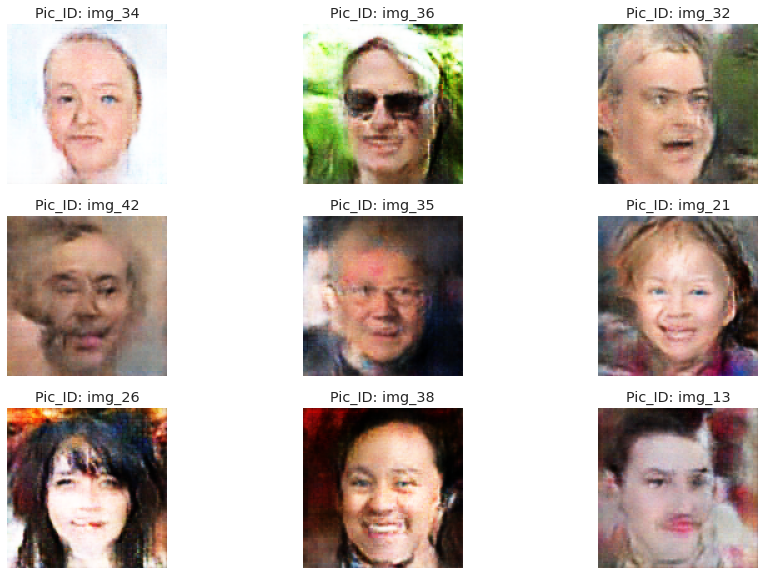

In [37]:
# Load pics
plt.figure(figsize = (15,10))
for i in range(9):
    rand_idx = int(np.random.uniform(0,len(generated_img)))
    im = PIL.Image.open(generated_img[rand_idx])
    plt.subplot(3, 3, i + 1)
    plt.imshow(im)
    label = (generated_img[rand_idx]).stem
    plt.title('Pic_ID: ' + str(label))
    plt.axis('off')
plt.show()

In [38]:
def plot_loss(gen_loss, crit_loss):
    """Print Loss in train and val sets"""

    plt.subplots(1, figsize=(10,5))
    plt.suptitle('Loss and Accuracy')
    plt.plot(gen_loss, label="gen_loss")
    plt.plot(crit_loss, label="Critic_loss")
    plt.legend(loc='best')
    plt.ylabel("loss")

    plt.show()

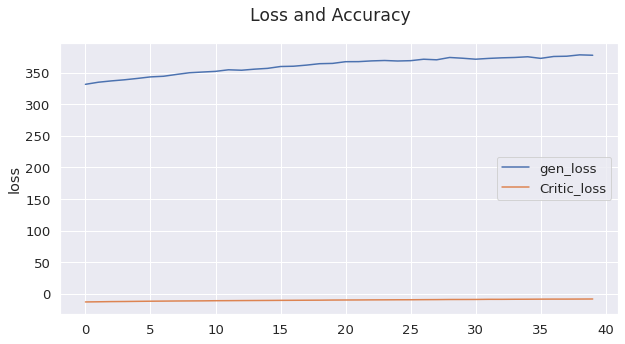

In [39]:
plot_loss(losses_gen,losses_critic)

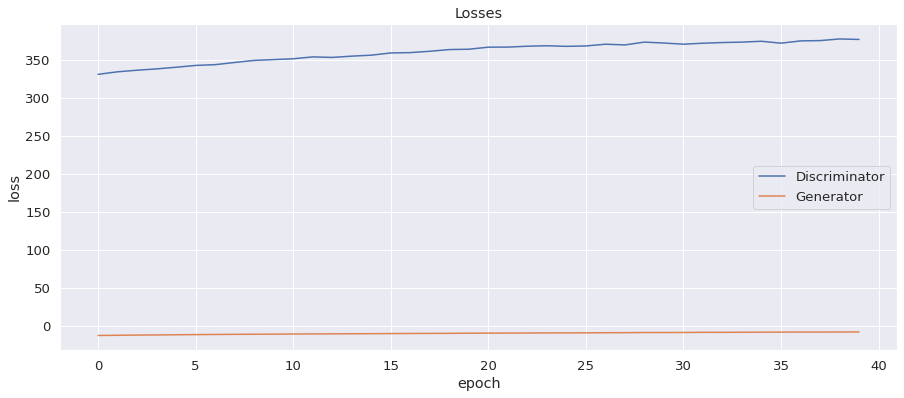

In [40]:
plt.figure(figsize=(15, 6))
plt.plot(losses_gen, '-')
plt.plot(losses_critic, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Как вам качество получившихся изображений?

Щляпа полная

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [41]:
with torch.no_grad():
  gen_pics = gen(fixed_noise)

In [42]:
len(train_files[:4000])

4000

In [43]:
generate_examples(gen,n=len(train_files[:4000]))
generated_img = sorted(list(Path(generated_img_path).rglob('*png')))

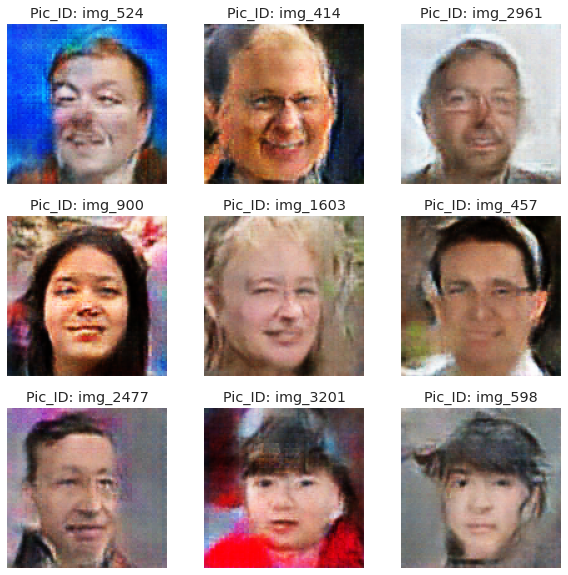

In [44]:
# Load pics
plt.figure(figsize = (10,10))
for i in range(9):
    rand_idx = int(np.random.uniform(0,len(generated_img)))
    im = PIL.Image.open(generated_img[rand_idx])
    plt.subplot(3, 3, i + 1)
    plt.imshow(im)
    label = (generated_img[rand_idx]).stem
    plt.title('Pic_ID: ' + str(label))
    plt.axis('off')
plt.show()

In [45]:
def get_flat(files,label,real=True):#(df,label,file):
  arr = np.empty((1, CHANNELS_IMG*IMAGE_SIZE*IMAGE_SIZE))
  for file in files:
    image = Image.open(file)
    image.load()
    if real:
      resize = transforms.Resize(IMAGE_SIZE)
      image = resize(image)
      
    img = np.array(image)
    img = img.flatten()
    img = np.expand_dims(img, axis=0)
    arr = np.vstack((arr,img))
  df_t = pd.DataFrame(data=arr[1:])
  df_t['label'] = label
  return df_t

In [46]:
fake_img = get_flat(generated_img,0, real=False)

In [50]:
real_img =  get_flat(train_files[:4000],1, real=True)

In [51]:
train_df = pd.concat([fake_img,real_img])

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [53]:
y = train_df[train_df.columns[-1]].values
X = train_df[train_df.columns[:-1]].values

In [54]:
error = []
actual = []
predicted = []

In [55]:
loo = LeaveOneOut()

In [56]:
for train_index ,test_index in loo.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  classifier = KNeighborsClassifier(n_neighbors=1)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  # Append the single predictions and actual values here.
  actual.append(y_test[0])
  predicted.append(y_pred[0])

# Outside the loop, calculate the error.
error.append(np.mean(np.array(predicted) != np.array(actual)))

In [57]:
accuracy_score(actual, predicted)

0.568875

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [58]:
from sklearn.manifold import TSNE
import plotly.express as px

In [59]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(train_df.drop(['label'],axis=1))

In [60]:
fig = px.scatter(tsne_results,
                 x=0,
                 y=1,
                 color=train_df.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

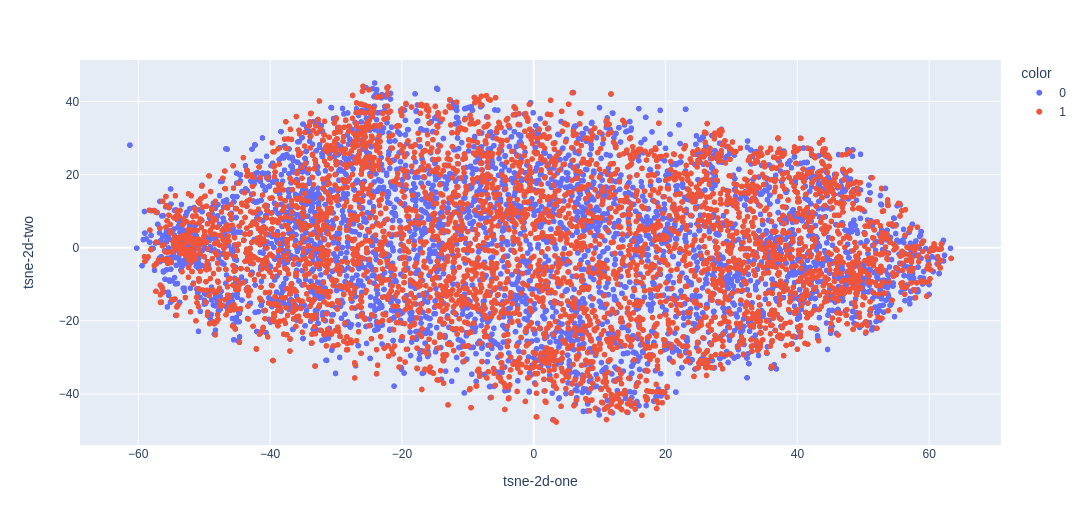

Прокомментируйте получившийся результат: